In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold


In [2]:

df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\3 Feature Selection\contData_all_Avg - 1o2.csv')
df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\3 Feature Selection\contData_all_Avg - 2o2.csv')

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

# Concatenate (union) the dataframes
df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)



In [3]:
selected_columns = ['Butanol', 
                    'FC55569',
                    'DI55152',
                    '425 %Al',
                    'TC55552',
                    'FC55003',
                    'LC55555',
                    'FFC55553',
                    'FFC55555',
                    'TC55555',
                    'TI55021',
                    'PI55004',
                    'FC55552'
                    ]
existing_columns = [col for col in selected_columns if col in df_All.columns]
df_All = df_All[existing_columns]

print(df_All.head())

     Butanol      FC55569   DI55152   425 %Al     TC55552    FC55003  \
0  30.366200  6928.310000  0.924879  6.319560  178.773000  5622.8300   
1  30.678500  6924.645000  0.924515  6.319915  179.011500  5308.8850   
2  32.399333  6925.813333  0.929955  6.328340  180.276667  5489.7400   
3  32.845950  6920.290000  0.932388  6.336760  180.993250  5709.1825   
4  33.387025  6916.018000  0.934531  6.337460  181.511000  5653.1640   

     LC55555  FFC55553  FFC55555   TC55555  TI55021   PI55004   FC55552  
0  60.362200  1.045930  0.752379  179.6930  213.813  1.044590  40424.10  
1  60.446750  1.049540  0.751183  179.9940  213.874  1.236360  40409.25  
2  60.350800  1.050217  0.761243  180.0530  214.433  1.189883  40606.30  
3  60.118475  1.050780  0.766600  180.5790  214.639  1.343838  39171.20  
4  60.150020  1.051672  0.770305  180.2476  214.733  1.535224  39099.64  


In [4]:
# Set max columns to display
pd.set_option('display.max_columns', None)

### Include

### Exlcude

In [5]:
# # List of columns to exclude to run XGboost feature selection
# exclude_columns = [#'Date', 
#                    #'FFC55553' ,'LC55555', 'FC55003', 'LC55557', 'FFC55555','LC55553', 
#                    'TI55021', 'TC55555', 'Decanol'
                   
#                    ]

# # Create a new DataFrame without the excluded columnsd
# df_All = df_All.drop(columns=exclude_columns)

In [6]:
df_All.columns

Index(['Butanol', 'FC55569', 'DI55152', '425 %Al', 'TC55552', 'FC55003',
       'LC55555', 'FFC55553', 'FFC55555', 'TC55555', 'TI55021', 'PI55004',
       'FC55552'],
      dtype='object')

In [7]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [8]:
# df_All.drop('Date', axis=1, inplace=True)

In [9]:
print(df_All.describe())

            Butanol       FC55569       DI55152       425 %Al       TC55552  \
count  49239.000000  49239.000000  49239.000000  49239.000000  49239.000000   
mean       8.938060   6597.603766      0.941467      6.128382    168.734200   
std        8.759664    354.077661      0.039434      0.258963     15.133759   
min        0.361524   5227.756250      0.820011      5.085695    121.490875   
25%        3.710000   6379.216250      0.915246      5.989670    156.098687   
50%        5.704607   6573.695000      0.937841      6.131580    172.376000   
75%       10.096646   6801.608125      0.961515      6.271303    180.775750   
max       55.772500   7982.280000      1.062941      7.170805    201.847250   

            FC55003       LC55555      FFC55553      FFC55555       TC55555  \
count  49239.000000  49239.000000  49239.000000  49239.000000  49239.000000   
mean    5961.207018     57.983777      0.993808      0.774193    180.979496   
std      755.225407     10.548250      0.038780    

In [10]:
# Assuming your data is in filtered_df and you want to predict 'target_column_name'
X = df_All.drop('Butanol', axis=1)  # Replace 'target_column_name' with your target column's name
y = df_All['Butanol']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate=0.03,
    n_estimators=600,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=2.0,
    alpha=0.2,
    reg_lambda=2,
    colsample_bylevel=0.8,
    colsample_bynode=0.7
)
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=0.8,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
# Predict on training data
y_train_pred = xgb_model.predict(X_train)

# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on Training Data: {mse_train}")



# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Data: {mse}")

Mean Squared Error on Training Data: 9.325773856034674
Mean Squared Error on the Testing Data: 15.659606278777401


In [12]:
rmse_train = np.sqrt(mse_train)
print(f"Root Mean Squared Error on Training Data: {rmse_train}")


rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on the Testing Data: {rmse}")


Root Mean Squared Error on Training Data: 3.053813002794158
Root Mean Squared Error on the Testing Data: 3.9572220406210974


In [13]:
# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f"R-squared value on Training Data: {r2_train:.2f}")


# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared value on the Testing Data: {r2:.2f}")

R-squared value on Training Data: 0.88
R-squared value on the Testing Data: 0.79


In [14]:
current_features = X.columns.tolist()

# Calculate Adjusted R-squared
def adjusted_r2(r2, n, k):
    """
    Compute the adjusted R^2 from R^2, number of samples (n) and number of predictors (k).
    
    Args:
    - r2 (float): R^2 value
    - n (int): number of samples
    - k (int): number of predictors

    Returns:
    - float: adjusted R^2 value
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


adj_r2 = adjusted_r2(r2, len(y_test), len(current_features))

print(f"Adjusted R^2 value: {adj_r2}")

Adjusted R^2 value: 0.7944871055122703


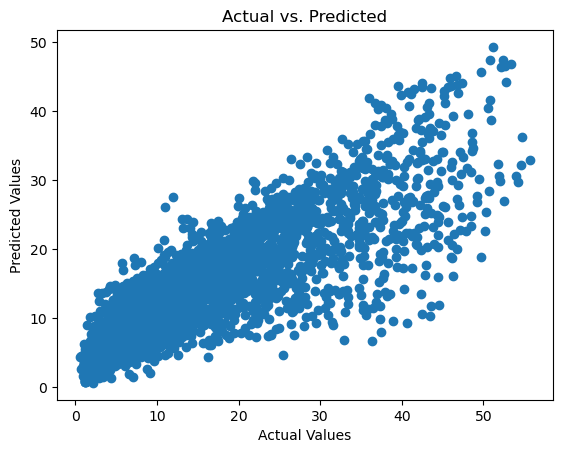

In [15]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()


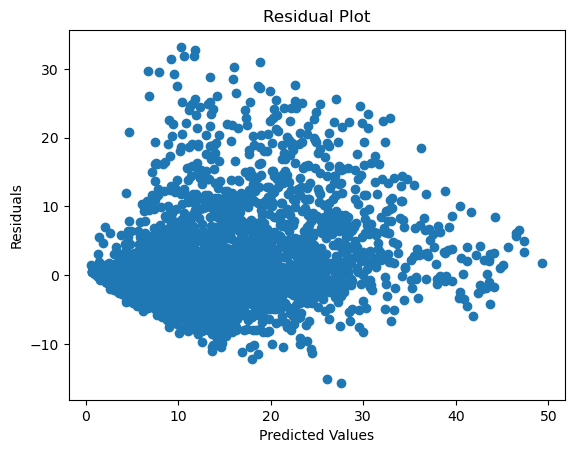

In [16]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [17]:
num_rows = df_All.shape[0]

splits = num_rows//10000

if splits < 5:
    splits = 5

In [18]:
# Define the K-fold cross validator
kfold = KFold(n_splits=splits, shuffle=True, random_state=42)

# Perform K-fold cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Take the square root of the scores to get the RMSE
rmse_scores = np.sqrt(-scores)

# Print out the results
print(f'Scores for each fold are: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard deviation of RMSE: {np.std(rmse_scores)}')

Scores for each fold are: [3.86767334 3.90806578 3.99659674 3.89610678 4.09351361]
Average RMSE: 3.952391250496004
Standard deviation of RMSE: 0.08267945177089578


In [19]:
df_All.columns

Index(['Butanol', 'FC55569', 'DI55152', '425 %Al', 'TC55552', 'FC55003',
       'LC55555', 'FFC55553', 'FFC55555', 'TC55555', 'TI55021', 'PI55004',
       'FC55552'],
      dtype='object')